In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import json
from osgeo import gdal
import rasterio 

DATAPATH =  r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data' #sorry for the hardcoding

In [2]:
test = r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\120x120\positive\198_2019-01-31T10_06_36.654Z_1.tif'
test = r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\300x300\positive\0000__S2A-MSIL2A-ST20200104T110726-N0213-R094-T30UYV-20200104T122020.tif'

def avg_std_geotiff(filepath):
    raster = gdal.Open(filepath)
    bands = raster.RasterCount
    # print(bands)
    avg = []
    std = []
    for band in range(1, bands + 1):
        data = raster.GetRasterBand(band).ReadAsArray()
        mean = np.mean(data)
        avg.append(mean)
        std.append(np.std(data))
    return np.array(avg),np.array(std)

avg_std_geotiff(r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\300x300\positive\0000__S2A-MSIL2A-ST20200317T111723-N0214-R137-T30UYV-20200317T123526.tif')

c:\Users\timvd\anaconda3\envs\UC-env\Lib\site-packages\osgeo\gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


(array([ 572.011     ,  677.72108889,  861.75163333,  888.69652222,
        1141.23667778, 1494.15074444, 1604.41      , 1749.59614444,
        1710.58457778, 1814.85423333,    0.        , 1477.4118    ,
        1085.92193333]),
 array([ 416.73533945,  714.10576972,  737.75909249,  793.235567  ,
         690.13298193,  796.17270882,  849.74251361, 1036.53976057,
         893.90357475,  744.37554767,    0.        ,  680.89264592,
         543.68684736]))

In [3]:
DATAPATH =  r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data' #sorry for the hardcoding
labels = pd.read_csv(os.path.join(DATAPATH,'labels.csv')) 

label_filenames = labels['filename'].values
new_label_filenames = [l.replace(":","_") for l in label_filenames]
labels['filename'] = new_label_filenames


#We see that fuel type, coordinates, weather data and generation output rate
classification_labels = labels[['filename','fuel_type']].copy()
regression_labels = labels[['filename','gen_output']].copy()
weather_data = labels[['filename','temp','wind-u','wind-v','humidity']].copy()

for ftype,count in zip(*np.unique(labels['fuel_type'].values,return_counts=True)):
    print(f'{ftype}: {count}')

Fossil Brown coal/Lignite: 619
Fossil Coal-derived gas: 63
Fossil Gas: 476
Fossil Hard coal: 926
Fossil Oil: 3
Fossil Peat: 44


In [27]:
regr = labels['gen_output'].values
len(regr), np.nonzero(regr)[0].shape[0]

(2131, 1718)

In [4]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import typing

def create_split(data: pd.DataFrame) ->typing.Tuple[typing.List[str]]:
    data_shuffle = shuffle(data,random_state=42)
    oil_instances = data_shuffle['filename'][data_shuffle['fuel_type'].values == 'Fossil Oil'].values #hard-coded since there's only 3 of them
    # train,val,test = [oil_instances[0]],[oil_instances[1]],[oil_instances[2]]
    data_shuffle = data_shuffle[np.invert(np.isin(data_shuffle['filename'].values,oil_instances))] #remove oil instances
    N = data_shuffle.shape[0]
    train_val, test = train_test_split(data_shuffle['filename'].values,test_size=0.1)
    train,val = train_test_split(train_val,test_size=0.11) #0.11 since it should contribute 10% of the whole dataset
    train = np.append(train,oil_instances[0])
    val = np.append(val,oil_instances[1])
    test = np.append(test,oil_instances[2])
    return train,val,test

train,val,test = create_split(labels)
train.shape[0]+val.shape[0]+test.shape[0], labels.shape[0]

(2131, 2131)

In [5]:
assert len(labels[np.isin(labels['filename'].values,train)]['fuel_type'].unique()) == 6, 'Training does not have all fuel types'
assert len(labels[np.isin(labels['filename'].values,val)]['fuel_type'].unique()) == 6, 'Validation does not have all fuel types'
assert len(labels[np.isin(labels['filename'].values,test)]['fuel_type'].unique()) == 6, 'Test does not have all fuel types'

In [6]:
for file in os.listdir(r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\120x120\positive'):
    label = labels[labels['filename'] == file]['fuel_type'].iloc[0]
    print(label)

Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown coal/Lignite
Fossil Brown

In [7]:
with open(r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\segmentation_labels\segmentation_labels\training\120x120\212846_2019-10-31T11_06_38.322Z_17_features.json') as file:
    test = json.load(file)
    file.close()
test

{'completions': [{'created_at': 1600948675,
   'id': 4453001,
   'lead_time': 15.079,
   'result': [{'from_name': 'label',
     'id': 'U0jM1o0P7H',
     'image_rotation': 0,
     'original_height': 120,
     'original_width': 120,
     'parent_id': None,
     'source': '$image',
     'to_name': 'image',
     'type': 'polygonlabels',
     'value': {'points': [[67.83333841964809, 58.16667175298142],
       [58.66667175298142, 58.00000508631475],
       [51.16667175298142, 53.83333841964809],
       [45.50000508631476, 48.33333841964809],
       [41.00000508631476, 47.33333841964809],
       [31.500005086314758, 50.00000508631476],
       [25.333338419648094, 51.83333841964809],
       [20.333338419648094, 51.50000508631476],
       [23.666671752981426, 47.00000508631476],
       [31.166671752981426, 44.33333841964809],
       [36.66667175298142, 42.83333841964809],
       [44.16667175298142, 41.16667175298142],
       [53.00000508631476, 45.83333841964809],
       [57.833338419648086, 50

In [8]:
def walk_seg_labels():
    train120 = []
    train300 = []
    val = []
    filenames = []

    for roots,dirs,files in os.walk(os.path.join(DATAPATH,'segmentation_labels')):
        for f in files:
            try:
                if "DS_Store" in f:
                    raise FileNotFoundError("Skippable file.")
                # jsonfile = json.loads(os.path.join(roots,f))
                with open(os.path.join(roots,f),encoding='utf-8') as file:
                    jsonfile = json.load(file)
                #     # print(roots)
                #     # print(os.path.join(roots,files[0]))
                    file.close()
                
                filenames.append(f.split('_features.json')[0])
                # filenames.append(f.split('.')[0])
                if '120x120' in roots:
                    train120.append(jsonfile)
                elif '300x300' in roots:
                    train300.append(jsonfile)
                elif 'validation' in roots:
                    val.append(jsonfile)
                else:
                    print(jsonfile)
                    raise ValueError("Somehow an invalid JSON file was read.")

            except (IndexError,FileNotFoundError,json.JSONDecodeError) as e:
                print(f'ERROR FOR: {f}: {e}')
                continue

    return train120,train300,val,filenames

def walk_images():
    filenames = []
    means = np.zeros(13)
    stds = np.zeros(13)
    counter = 0
    for roots,dirs,files in os.walk(os.path.join(DATAPATH,'images')):
        for f in files:
            if 'DS' in f or f in filenames:
                continue
            filenames.append(f)
            if 'training' in roots:
                mean,std = avg_std_geotiff(os.path.join(roots,f))
                means += mean
                stds += std
                counter += 1
    
    means /= counter
    stds /= counter
    return filenames,means,stds

image_filenames, means, stds, = walk_images()
print('Means:',means)
print('Stnd. dev.:',stds)

Means: [ 933.38013839 1004.11463105 1137.02170809 1135.42433858 1422.51752715
 1951.55696681 2131.60578229 2224.28952514 2240.30151012 2444.14637075
   18.35374611 1798.78541339 1371.89794305]
Stnd. dev.: [ 655.93300999  817.69329966  813.46889223  869.14764332  843.05482553
  956.79021728 1027.68464861 1136.60029386 1061.58152948 1074.80846898
    4.95420989  843.95646992  778.02741191]


In [9]:
train120,train300,val,seg_filenames = walk_seg_labels()
len(val),len(train120),len(train300),len(val)+len(train120)+len(train300),len(seg_filenames)

ERROR FOR: .DS_Store: Skippable file.
ERROR FOR: ._.DS_Store: Skippable file.


(73, 560, 938, 1571, 1571)

In [10]:
filename_mask = np.isin(new_label_filenames,image_filenames)
print(sum(filename_mask))
labels[filename_mask]

2125


,filename,country,fuel_type,lat,lon,temp,wind-u,wind-v,humidity,gen_output
0,0000__S2B-MSIL2A-ST20200122T111720-N0213-R137-...,NaN,Fossil Gas,49.480000,0.220000,278.305176,0.004515,4.226044,82.740540,522.00
1,0046__S2B-MSIL2A-ST20200113T104630-N0213-R008-...,NaN,Fossil Coal-derived gas,51.492197,6.727517,281.209442,0.006401,6.036209,95.168945,261.75
2,0002__S2B-MSIL2A-ST20200122T111720-N0213-R137-...,NaN,Fossil Hard coal,49.473119,0.145785,278.305176,0.004515,4.226044,82.740540,490.00
3,0000__S2A-MSIL2A-ST20200104T110726-N0213-R094-...,NaN,Fossil Gas,49.480000,0.220000,275.573242,0.004171,-3.539032,91.366272,142.00
4,0046__S2B-MSIL2A-ST20200113T104631-N0213-R008-...,NaN,Fossil Coal-derived gas,51.492197,6.727517,281.209442,0.006401,6.036209,95.168945,261.75
...,...,...,...,...,...,...,...,...,...,...
2126,46405_2019-10-02T10_35_39.153Z_0.tif,Germany,Fossil Hard coal,54.142813,12.132942,284.489777,6.844803,-2.311661,60.229195,339.23
2127,46405_2019-10-07T10_35_40.952Z_0.tif,Germany,Fossil Hard coal,54.142813,12.132942,279.732239,0.855591,-1.933838,74.679741,504.63
2128,2450_2019-10-12T10_37_13.780Z_0.tif,Germany,Fossil Hard coal,48.719120,9.371298,293.213806,1.626221,2.559738,57.040428,0.00
2129,2450_2019-10-14T10_27_19.241Z_0.tif,Germany,Fossil Hard coal,48.719120,9.371298,295.094391,-1.124039,-0.288925,58.943527,0.00


In [11]:
def cross_ref_seg_with_labels(seg_filenames=seg_filenames,label_filenames=new_label_filenames):
    new_label_filenames = [l.split('.')[0] for l in label_filenames]
    print(len(new_label_filenames))
    print(len(seg_filenames))
    print(len(new_label_filenames) - len(seg_filenames))
    return np.isin(seg_filenames,new_label_filenames).sum()

cross_ref_seg_with_labels()

2131
1571
560


940

In [12]:
sum([new_label_filenames.count(l) > 1 for l in image_filenames])

0

visualizing a plot

13


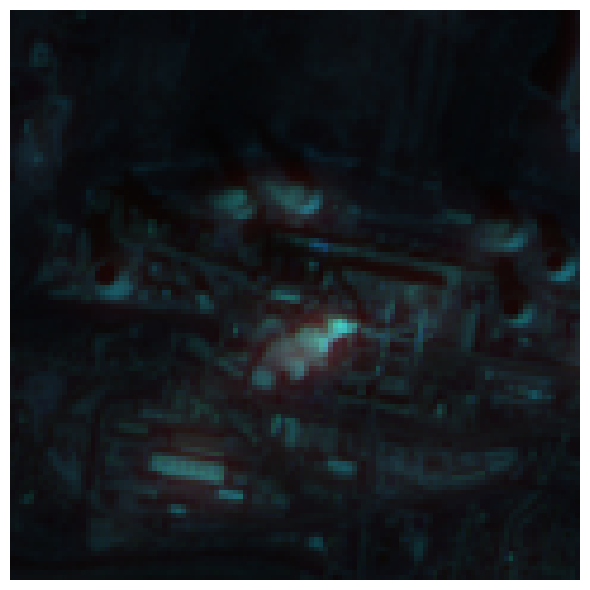

In [13]:
vis = r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\120x120\positive\198_2019-04-16T10_12_09.368Z_11.tif'
import rasterio as rio
import rasterio.plot
import numpy as np
import matplotlib.pyplot as plt

tiff = rio.open(vis)
image = tiff.read([1,2,3])
image = np.clip(image / 10000, 0, 255)
print(tiff.count)
fig,ax = plt.subplots(figsize=(6,6))
rasterio.plot.show(image,ax=ax)
plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
from osgeo import gdal
testfile = r'C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\120x120\positive\198_2019-02-15T10_06_39.586Z_2.tif'
print(gdal.Info(testfile))

Driver: GTiff/GeoTIFF
Files: C:\Users\timvd\Documents\Uni_2024-2025\UC\Project\ProjectCode\data\images\images\training\120x120\positive\198_2019-02-15T10_06_39.586Z_2.tif
Size is 120, 120
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 33N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 33N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",15,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",880